# EcoFOCI C2 near sfc Datasets

- erddap source: https://akutan.pmel.noaa.gov/erddap
- 2010+
- CK
- Mooring/Prawler (upper 2-5m of prawler data if needed otherwise, bridle-mounted instrument

***Todo:***
- compare against upper 1m and upper 5m (winds should tell if the two are identical) (Niller - mixing for winds)
- standard deviation of daily means of C2 SST
- daily variability (seasonally)
- find M8 paper (because this has info on how good M8 was vs M2 and what model we used with most reliability)

**Other Sites**
- See [EcoFOCI_M2.ipynb](EcoFOCI_M2.ipynb)

In [1]:
import datetime
from erddapy import ERDDAP
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

#using xarray for bathymetry data read
import xarray as xa

In [2]:
#search and boundary parameters

server_url = 'http://akutan.pmel.noaa.gov:8080/erddap/'

deployments = []

constraints = {
    'time>=': '2010-01-01T00:00:00Z',
    'time<=': datetime.datetime.utcnow().strftime('%Y-%m-%dT00:00:00Z'),
    'depth>=': 0,
    'depth<=': 5,
}

extent=[-179.5, -150, 66, 75]
variables = ['latitude, longitude, temperature, time, depth']


In [18]:
e = ERDDAP(server=server_url)
df_1 = pd.read_csv(e.get_search_url(response='csv', search_for='ckp2 -ADCP -gridded -preliminary'))
df_1b = pd.read_csv(e.get_search_url(response='csv', search_for='ckip2 -ADCP -gridded -preliminary'))
e = ERDDAP(server=server_url)
df_2 = pd.read_csv(e.get_search_url(response='csv', search_for='datasets_Mooring_19ckitaepr2a_final'))
df_3 = pd.read_csv(e.get_search_url(response='csv', search_for='datasets_Mooring_17ckitaepr2a_final'))
df = pd.concat([df_1,df_1b,df_2,df_3])
print(df['Dataset ID'].values)

['datasets_Mooring_13ckp2a_final' 'datasets_Mooring_14ckp2a_final'
 'datasets_Mooring_15ckp2a_final' 'datasets_Mooring_16ckp2a_final'
 'datasets_Mooring_17ckp2a_final' 'datasets_Mooring_18ckp2a_final'
 'datasets_Mooring_19ckp2a_final' 'datasets_Mooring_10ckip2a_final'
 'datasets_Mooring_11ckip2a_final' 'datasets_Mooring_12ckip2a_final'
 'datasets_Mooring_16ckip2a_final' 'datasets_Mooring_17ckip2a_final'
 'datasets_Mooring_18ckip2a_final' 'datasets_Mooring_19ckitaepr2a_final'
 'datasets_Mooring_17ckitaepr2a_final']


In [19]:
from requests.exceptions import HTTPError

dfs = {}
for dataset_id in df['Dataset ID'].values:
    print(dataset_id)
    try:
        d = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        d.dataset_id=dataset_id
        d.variables = variables
        d.constraints = constraints
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))

    try:
        df_m = d.to_pandas(
                    index_col='time (UTC)',
                    parse_dates=True,
                    skiprows=(1,)  # units information can be dropped.
                    )
        df_m.sort_index(inplace=True)
        df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
        
        
        #-9999 and 1e35 are missing values... but erddap doesn't catch the -9999 yet 
        #and some 1e35 are off a bit
        df_m['depth'][(df_m.depth == -9999)] = np.nan # only in pressure field
        
        dfs.update({dataset_id:df_m})
    except:
        pass


datasets_Mooring_13ckp2a_final
datasets_Mooring_14ckp2a_final
datasets_Mooring_15ckp2a_final
datasets_Mooring_16ckp2a_final
datasets_Mooring_17ckp2a_final
datasets_Mooring_18ckp2a_final
datasets_Mooring_19ckp2a_final
datasets_Mooring_10ckip2a_final
datasets_Mooring_11ckip2a_final
datasets_Mooring_12ckip2a_final
datasets_Mooring_16ckip2a_final
datasets_Mooring_17ckip2a_final
datasets_Mooring_18ckip2a_final
datasets_Mooring_19ckitaepr2a_final
datasets_Mooring_17ckitaepr2a_final


**Note**  
1 Mooring data is hourly or better.  resample (on average) to daily (which will currently average all values from 0-5m)  
2 Prawler data is near sfc  


In [20]:
dfh= {}
dfstd={}
for dataset in dfs:
    #dfs[dataset].dropna(subset=['temperature'],inplace=True)
    dfh[dataset] = (dfs[dataset].resample('1D').mean())
    dfstd[dataset] = (dfs[dataset].resample('1D').std())

#groupby hour and see if there is a daily trend
dfg={}
dfg_std={}
for dataset in dfs:
    dtemp = dfs[dataset][(dfs[dataset].index.month >= 8) & (dfs[dataset].index.month <=8)]
    dfg[dataset] = (dtemp.groupby(dtemp.index.hour).mean())
    dfg_std[dataset] = (dtemp.groupby(dtemp.index.hour).std())


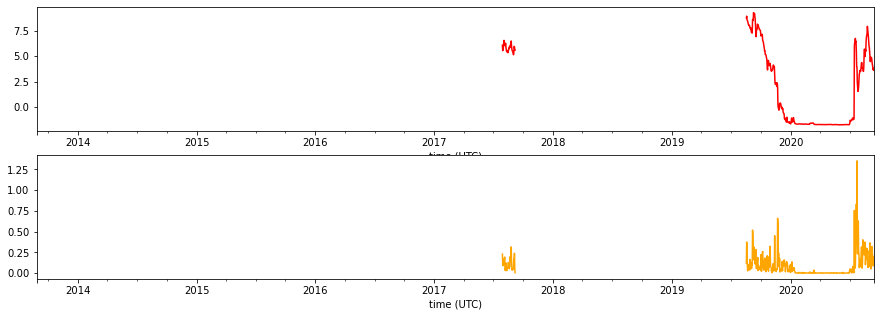

In [21]:
#daily thermal cycle
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(10, 5), facecolor='w', edgecolor='k')
for dataset in dfh:
    (dfh[dataset].temperature).plot(color='red',figsize=(15,5),ax=ax1)
    (dfstd[dataset].temperature).plot(color='orange',figsize=(15,5),ax=ax2)

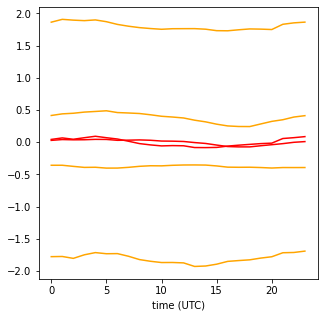

In [22]:
fig, ax1 = plt.subplots(1,1, figsize=(5, 5), facecolor='w', edgecolor='k')
for dataset in dfh:
    (dfg[dataset].temperature-dfg[dataset].temperature.mean()).plot(color='red',ax=ax1)
    (dfg[dataset].temperature-dfg[dataset].temperature.mean()+dfg_std[dataset].temperature).plot(color='orange',ax=ax1)
    (dfg[dataset].temperature-dfg[dataset].temperature.mean()-dfg_std[dataset].temperature).plot(color='orange',ax=ax1)

So - there is a small diurnal trend in the average, but is it much smaller than the retrieval/satellite sensitivity? but its not likely to matter if its morning or evening data point for this comparison, more importantly would be how the analysis sees strong events that set the variability.

In [23]:
#open_dataset vs load_dataset
# as this is a stationary dataset, i can really zoom in on the region

#HROISST
xa_HROISST = xa.open_mfdataset('/Users/bell/in_and_outbox/data_sets/sst/NBS_SST_Models/HROISSTV2/NBS_CK_HROISST_*.nc')

xa_HROISST_subset = xa_HROISST.sel(time=slice('2010-01-01','2020-12-31'),
                                     latitude=slice(71,71.3),longitude=slice(193.6,193.85))

#UKMET
#centered at noon
xa_UKMET = xa.open_mfdataset('/Users/bell/in_and_outbox/data_sets/sst/NBS_SST_Models/UKMET/NBS_CK_UKMET_*.nc')

xa_UKMET_subset = xa_UKMET.sel(time=slice('2010-01-01','2020-12-31'),
                                     latitude=slice(71,71.3),longitude=slice(-164.4,-164.15))


#JPL MUR
xa_JPLMUR = xa.open_mfdataset('/Users/bell/in_and_outbox/data_sets/sst/NBS_SST_Models/JPLGHRSSTMUR/NBS_CK_MUR_*.nc')

xa_JPLMUR_subset = xa_JPLMUR.sel(time=slice('2010-01-01','2020-12-31'),
                                     latitude=slice(71,71.3),longitude=slice(-164.4,-164.15))



In [24]:
for dataset in dfs:
    print(dataset)
    dfh[dataset]['hroisst'] = np.nan
    dfh[dataset]['hroierr'] = np.nan
    dfh[dataset]['ukmetsst'] = np.nan
    dfh[dataset]['ukmeterror'] = np.nan
    dfh[dataset]['jplsst'] = np.nan
    dfh[dataset]['jplerror'] = np.nan
    for row, value in dfh[dataset].iterrows():
        if np.isnan(value['latitude']):
            continue
        dfh[dataset]['hroisst'][row] = xa_HROISST_subset.sst.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude'],
                                                    method='nearest')
        dfh[dataset]['hroierr'][row] = xa_HROISST_subset.sst.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude'],
                                                    method='nearest')
        dfh[dataset]['ukmetsst'][row] = xa_UKMET_subset.analysed_sst.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude']-360,
                                                    method='nearest')
        dfh[dataset]['ukmeterror'][row] = xa_UKMET_subset.analysis_error.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude']-360,
                                                    method='nearest')    
        dfh[dataset]['jplsst'][row] = xa_JPLMUR_subset.analysed_sst.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude']-360,
                                                    method='nearest')
        dfh[dataset]['jplerror'][row] = xa_JPLMUR_subset.analysis_error.sel(time=str(row),
                                                    latitude=value['latitude'],
                                                    longitude=value['longitude']-360,
                                                    method='nearest')   

datasets_Mooring_13ckp2a_final
datasets_Mooring_15ckp2a_final
datasets_Mooring_16ckp2a_final
datasets_Mooring_17ckp2a_final
datasets_Mooring_18ckp2a_final
datasets_Mooring_19ckitaepr2a_final
datasets_Mooring_17ckitaepr2a_final


datasets_Mooring_13ckp2a_final
datasets_Mooring_15ckp2a_final
datasets_Mooring_16ckp2a_final
datasets_Mooring_17ckp2a_final
datasets_Mooring_18ckp2a_final
datasets_Mooring_19ckitaepr2a_final
datasets_Mooring_17ckitaepr2a_final
datasets_Mooring_13ckp2a_final
datasets_Mooring_15ckp2a_final
datasets_Mooring_16ckp2a_final
datasets_Mooring_17ckp2a_final
datasets_Mooring_18ckp2a_final
datasets_Mooring_19ckitaepr2a_final
datasets_Mooring_17ckitaepr2a_final


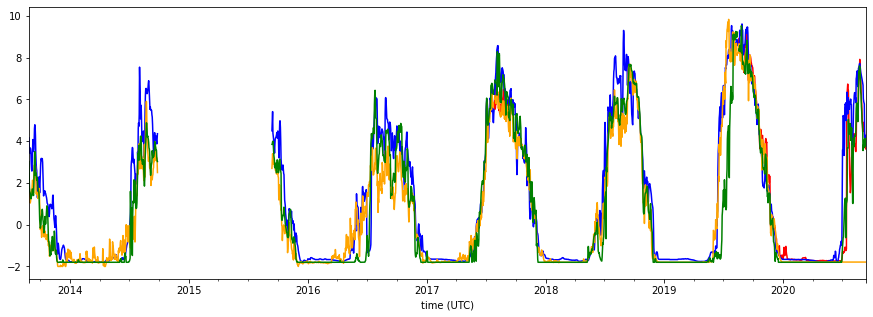

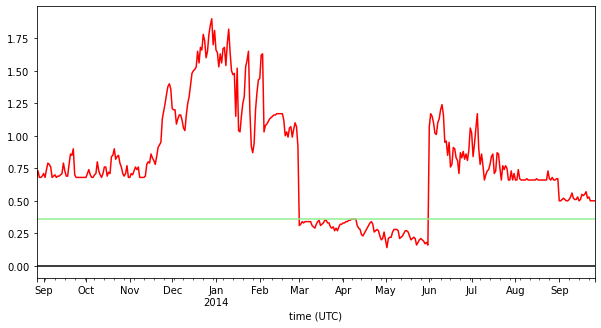

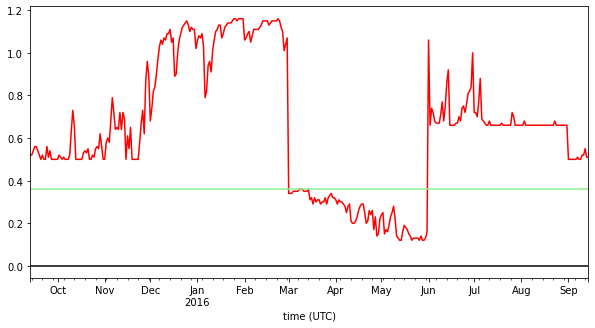

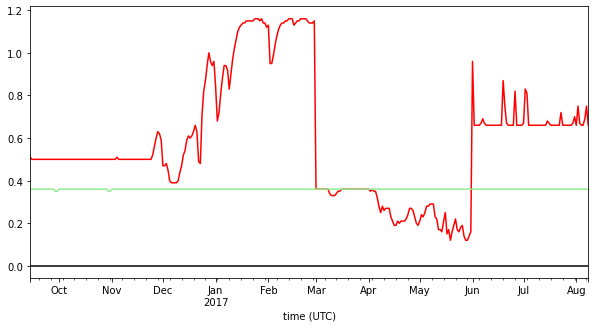

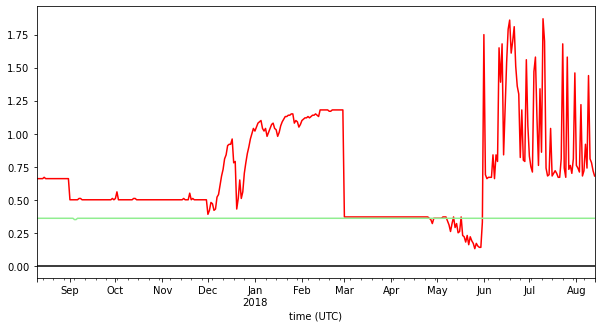

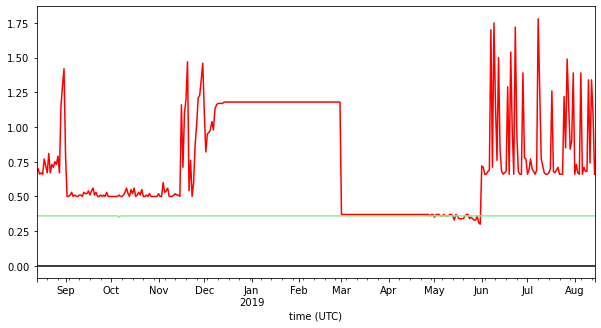

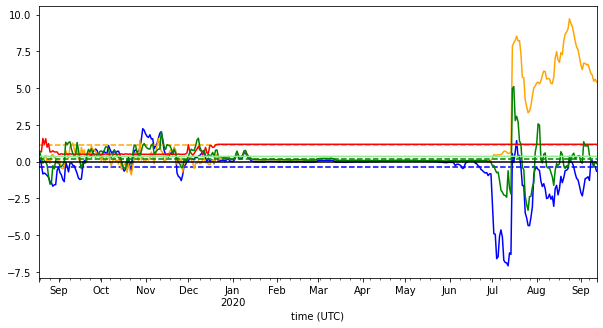

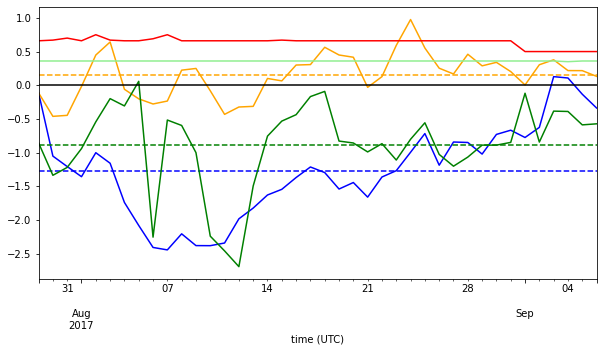

In [25]:
fig, axs = plt.subplots(1,1, figsize=(10, 5), facecolor='w', edgecolor='k')
for dataset in dfh:
    print(dataset)
    (dfh[dataset].temperature).plot(color='red',figsize=(15,5))
    (dfh[dataset].hroisst).plot(color='blue')
    (dfh[dataset].ukmetsst).plot(color='orange')
    (dfh[dataset].jplsst).plot(color='green')

    
for dataset in dfh:
    print(dataset)
    fig, axs = plt.subplots(1,1, figsize=(10, 5), facecolor='w', edgecolor='k')
    (dfh[dataset].temperature-dfh[dataset].hroisst).plot(color='blue',figsize=(10,5))
    (dfh[dataset].hroisst*0+(dfh[dataset].temperature-dfh[dataset].hroisst).mean()).plot(color='blue',linestyle='--')
    (dfh[dataset].temperature-dfh[dataset].ukmetsst).plot(color='orange')
    (dfh[dataset].ukmetsst*0+(dfh[dataset].temperature-dfh[dataset].ukmetsst).mean()).plot(color='orange',linestyle='--')
    dfh[dataset].ukmeterror.plot(c='red')
    (dfh[dataset].temperature-dfh[dataset].jplsst).plot(color='green')
    (dfh[dataset].jplsst*0+(dfh[dataset].temperature-dfh[dataset].jplsst).mean()).plot(color='green',linestyle='--')
    dfh[dataset].jplerror.plot(c='lightgreen')
    (dfh[dataset].ukmeterror*0).plot(c='black',linestyle='-')


### retrieve all sst data for 2010-2020 regardless of if a mooring exists or not

In [11]:
CK2_lat = 71.21232000000019
CK2_lon = 195.77764892578125

In [12]:
ckp_index = pd.date_range(start='2010-01-01', end='2020-12-31', freq='D')

In [13]:
ckp_allsst = pd.DataFrame(index=ckp_index)

In [14]:
ckp_allsst['jplsst'] = np.nan
ckp_allsst['jplice'] = np.nan

In [15]:
for row, value in ckp_allsst.iterrows():
    ckp_allsst['jplsst'][row] = xa_JPLMUR_subset.analysed_sst.sel(time=str(row),
                                            latitude=CK2_lat,
                                            longitude=CK2_lon-360,
                                            method='nearest')
    ckp_allsst['jplice'][row] = xa_JPLMUR_subset.sea_ice_fraction.sel(time=str(row),
                                            latitude=CK2_lat,
                                            longitude=CK2_lon-360,
                                            method='nearest')

In [16]:
ckp_allsst

,jplsst,jplice
2010-01-01,-1.8,0.92
2010-01-02,-1.8,0.93
2010-01-03,-1.8,0.95
2010-01-04,-1.8,0.96
2010-01-05,-1.8,0.93
...,...,...
2020-12-27,-1.8,0.98
2020-12-28,-1.8,0.98
2020-12-29,-1.8,0.97
2020-12-30,-1.8,0.95


In [17]:
ckp_allsst.to_csv('C2_JPLMUR_SSTpICEConc.csv')